<a href="https://colab.research.google.com/github/JulianDPastrana/signal_analysis/blob/main/A_simple_demonstration_of_coregionalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gpflow
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import gpflow
from gpflow.ci_utils import reduce_in_tests
gpflow.config.set_default_summary_fmt("notebook")

%matplotlib inline

plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(123)

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Coregionalization Model

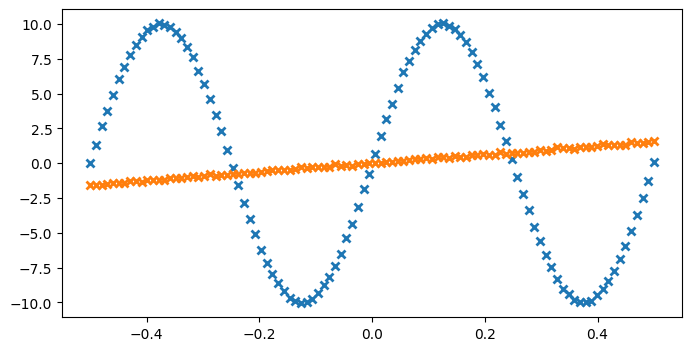

In [ ]:
# make a dataset with two outputs, correlated, heavy-tail noise. One has more noise than the other.
X1 = np.random.rand(100, 1)  # Observed locations for first output
X2 = np.random.rand(50, 1) * 0.5  # Observed locations for second output

# X1 = np.concatenate([np.linspace(-0.15, 0.15, 20), np.linspace(-0.15, 0.15, 20)+1])[:, None]
X1 = np.linspace(-0.5, 0.5, 100)[:, None]
X2 = X1.copy()
Y1 = 10 * np.sin(4 * np.pi * X1) + np.random.randn(*X1.shape) * 0.05
Y2 = np.pi * X2 + np.random.randn(*X2.shape) * 0.05

plt.figure(figsize=(8, 4))
plt.plot(X1, Y1, "x", mew=2)
plt.plot(X2, Y2, "x", mew=2)
plt.show()

(100, 2)


array([[ 1.        , -0.38057189],
       [-0.38057189,  1.        ]])

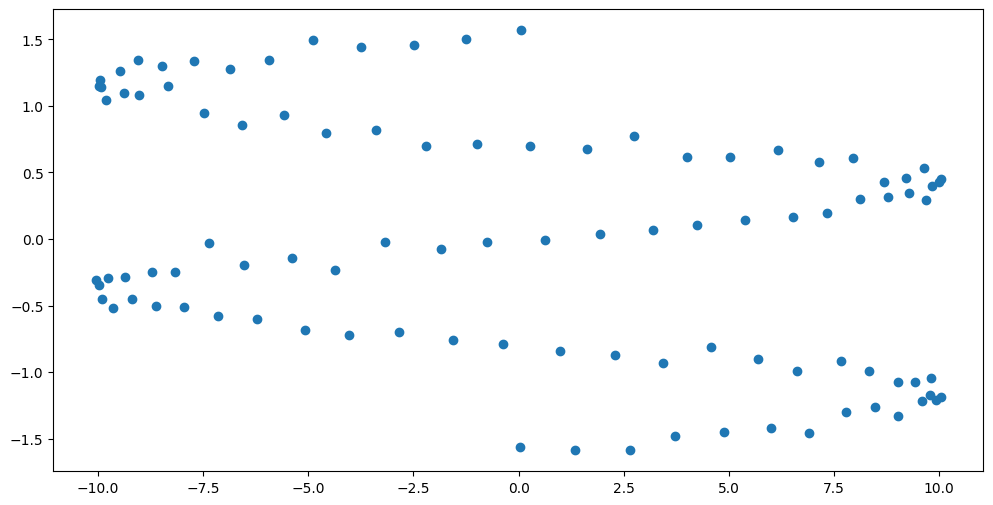

In [ ]:
plt.scatter(Y1, Y2)
M = np.concatenate([Y1, Y2], axis=1)
print(M.shape)
np.corrcoef(M, rowvar=False)

In [ ]:
# Augment the input with ones or zeros to indicate the required output dimension
X_augmented = np.vstack(
    (np.hstack((X1, np.zeros_like(X1))), np.hstack((X2, np.ones_like(X2))))
)

# Augment the Y data with ones or zeros that specify a likelihood from the list of likelihoods
Y_augmented = np.vstack(
    (np.hstack((Y1, np.zeros_like(Y1))), np.hstack((Y2, np.ones_like(Y2))))
)

In [ ]:
output_dim = 2  # Number of outputs
rank = 1  # Rank of W

# Base kernel
k = gpflow.kernels.Matern32(active_dims=[0])

# Coregion kernel
coreg = gpflow.kernels.Coregion(
    output_dim=output_dim, rank=rank, active_dims=[1]
)

# Base kernel
k2 = gpflow.kernels.SquaredExponential(active_dims=[0])

# Coregion kernel
coreg2 = gpflow.kernels.Coregion(
    output_dim=output_dim, rank=rank, active_dims=[1]
)


kern = k * coreg #+ k2 * coreg2

In [ ]:
# This likelihood switches between Gaussian noise with different variances for each f_i:
lik = gpflow.likelihoods.SwitchedLikelihood(
    [gpflow.likelihoods.Gaussian(), gpflow.likelihoods.Gaussian()]
)

# now build the GP model as normal
m = gpflow.models.VGP((X_augmented, Y_augmented), kernel=kern, likelihood=lik)

#fit the covariance function parameters
maxiter = reduce_in_tests(10000)
gpflow.optimizers.Scipy().minimize(
    m.training_loss,
    m.trainable_variables,
    options=dict(maxiter=maxiter),
    method="L-BFGS-B",
)

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 194.81506168778554
        x: [ 1.629e-01 -2.140e+00 ...  4.237e+01 -5.874e+00]
      nit: 10000
      jac: [ 1.237e+00 -2.889e-02 ...  5.071e-03  3.117e-02]
     nfev: 11162
     njev: 11162
 hess_inv: <20308x20308 LbfgsInvHessProduct with dtype=float64>

In [ ]:
# m.likelihood.likelihoods[0].variance.assign(1e-4)
# m.likelihood.likelihoods[1].variance.assign(1e-4)
# m.kernel.kernels[0].variance.assign(0.1)
gpflow.utilities.print_summary(m)

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,5.35196
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,10.90692
VGP.kernel.kernels[1].W,Parameter,Identity,,True,"(2, 1)",float64,[[12.20848] [-4.20912]]
VGP.kernel.kernels[1].kappa,Parameter,Softplus,,True,"(2,)",float64,[5.5e-04 9.0e-05]
VGP.likelihood.likelihoods[0].variance,Parameter,Softplus + Shift,,True,(),float64,42.36961
VGP.likelihood.likelihoods[1].variance,Parameter,Softplus + Shift,,True,(),float64,0.00281
VGP.num_data,Parameter,Identity,,False,(),int32,200
VGP.q_mu,Parameter,Identity,,True,"(200, 1)",float64,[[1.62860e-01...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 200, 200)",float64,"[[[3.7600e-03, 0.0000e+00, 0.0000e+00..."


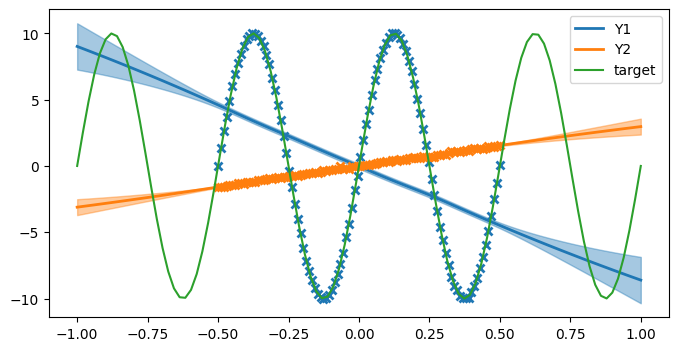

In [ ]:
def plot_gp(x, mu, var, color, label):
    plt.plot(x, mu, color=color, lw=2, label=label)
    plt.fill_between(
        x[:, 0],
        (mu - 2 * np.sqrt(var))[:, 0],
        (mu + 2 * np.sqrt(var))[:, 0],
        color=color,
        alpha=0.4,
    )


def plot(m):
    plt.figure(figsize=(8, 4))
    Xtest = np.linspace(-1, 1, 100)[:, None]
    (line,) = plt.plot(X1, Y1, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.zeros_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y1")

    (line,) = plt.plot(X2, Y2, "x", mew=2)
    mu, var = m.predict_f(np.hstack((Xtest, np.ones_like(Xtest))))
    plot_gp(Xtest, mu, var, line.get_color(), "Y2")
    plt.plot(Xtest, 10 * np.sin(4 * np.pi * Xtest), label="target")

    plt.legend()


plot(m)

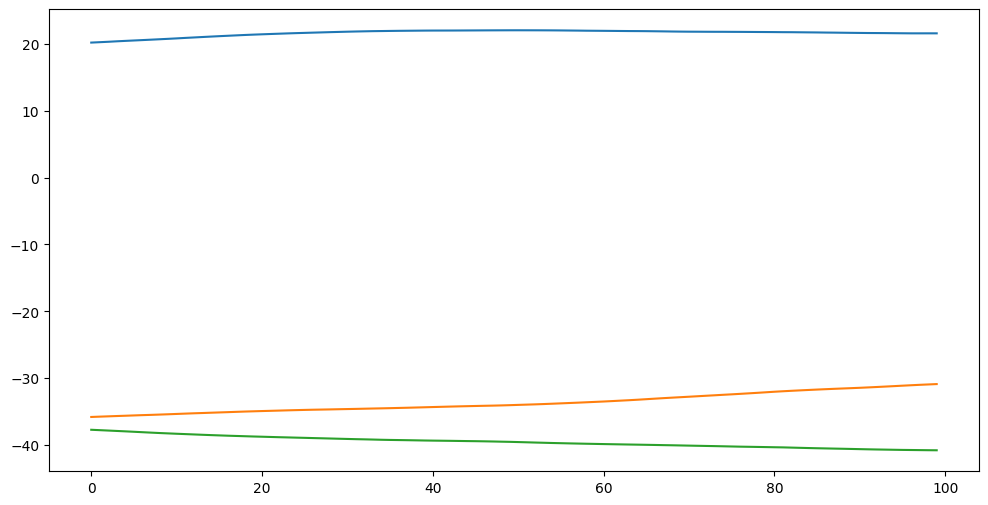

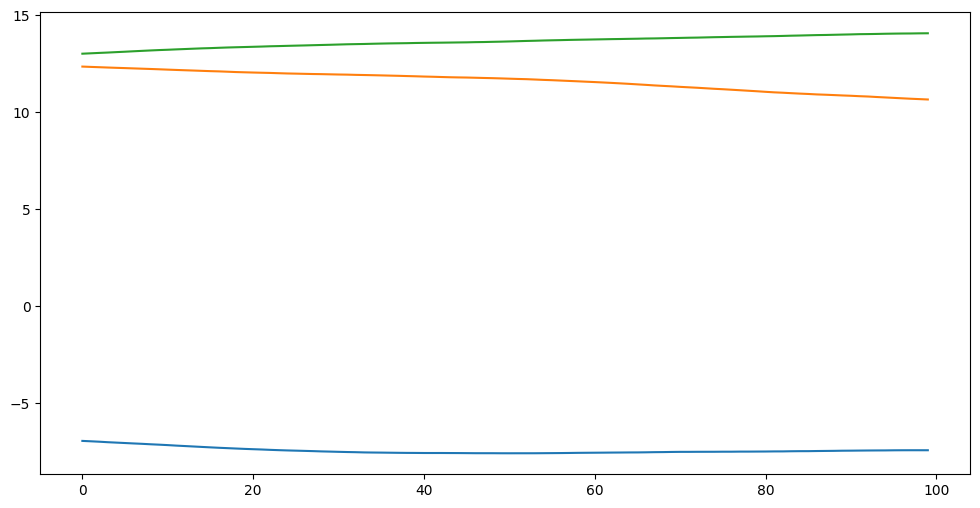

TensorShape([3, 200, 1])

In [ ]:
Xtest = np.linspace(10, 11, 100)[:, None]
X_test_augmented = np.vstack(
    (np.hstack((Xtest, np.zeros_like(Xtest))), np.hstack((Xtest, np.ones_like(Xtest))))
)
n_samples = 3
fs = m.predict_f_samples(X_test_augmented, n_samples)
plt.plot(fs[:, :100, 0].numpy().T)
plt.show()

plt.plot(fs[:, 100:, 0].numpy().T)
plt.show()

# fs = m.predict_f_samples(np.hstack((Xtest, np.ones_like(Xtest))), n_samples)
# plt.plot(fs[:, :, 0].numpy().T)
# plt.show()
fs.shape

<Axes: >

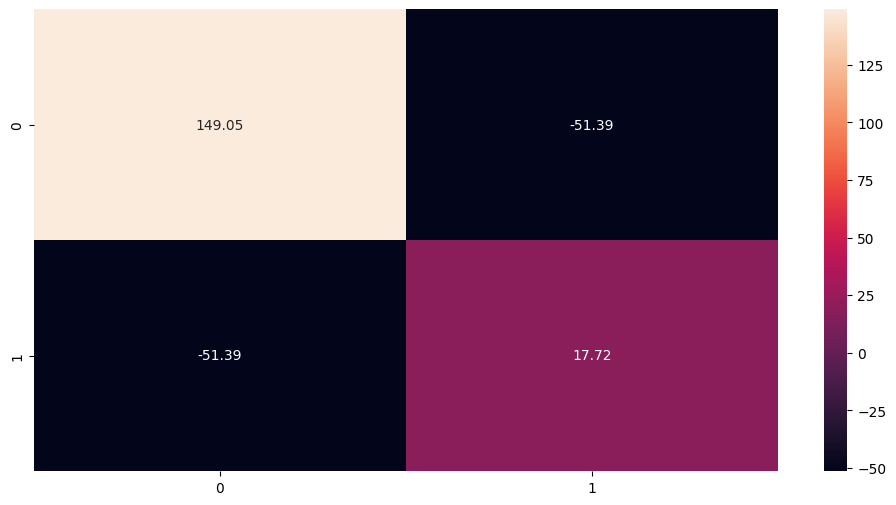

In [ ]:
B = coreg.output_covariance().numpy()
sns.heatmap(B, annot=True, fmt=".2f")

<Axes: >

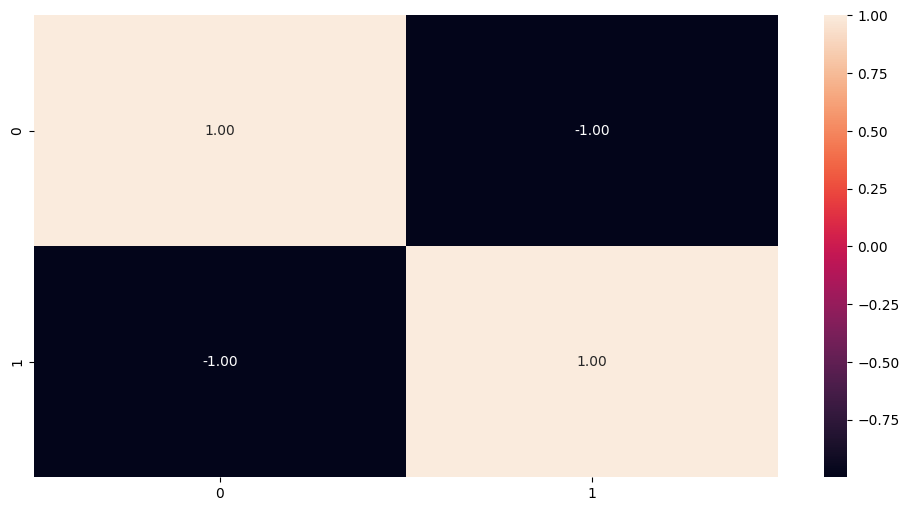

In [ ]:
sns.heatmap(correlation_from_covariance(B), annot=True, fmt=".2f")

# Shared independent multi-output kernel (MOK) and shared independent inducing variables

Here the priors on all outputs are constrained to have the same kernel hyperparameters. We also share the inducing inputs between all outputs. The different GPs are independent both in the prior and the approximate posterior.

In [ ]:
N = len(X)  # number of points
D = 1  # number of input dimensions
M = 15  # number of inducing points
L = 2  # number of latent GPs
P = 2  # number of observations = output dimensions

rng = np.random.default_rng(1234)
Zinit = rng.choice(X, size=M, replace=False)

Y = np.hstack([Y1, Y2])
data = (X, Y)

In [ ]:
def optimize_model_with_scipy(model):
    optimizer = gpflow.optimizers.Scipy()
    optimizer.minimize(
        model.training_loss_closure(data),
        variables=model.trainable_variables,
        method="l-bfgs-b",
        #options={"disp": 50, "maxiter": MAXITER},
    )

def plot_model(m, lower=0, upper=1):
    pX = np.linspace(lower, upper, 100)[:, None]
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(X, Y, "x")
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
    plt.xlabel("X")
    plt.ylabel("f")
    plt.title(f"ELBO: {m.elbo(data):.3}")
    plt.plot(Z, Z * 0.0, "o")

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.variance,Parameter,Softplus,,True,(),float64,2.17895
SVGP.kernel.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.35946
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.002
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-0.11358...
SVGP.q_mu,Parameter,Identity,,True,"(15, 2)",float64,"[[-4.31950e-01, -4.97160e-01..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 15, 15)",float64,"[[[-7.9100e-03, 0.0000e+00, 0.0000e+00..."


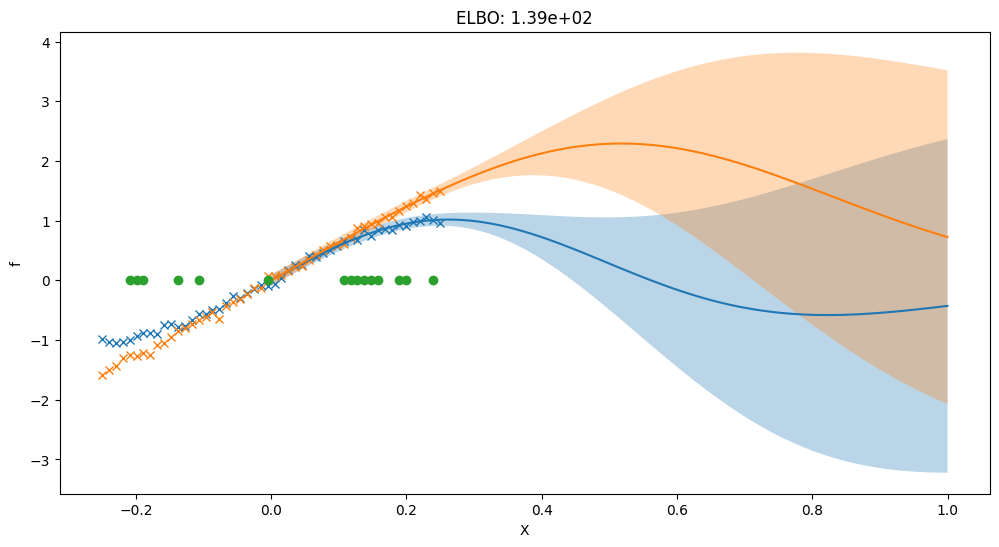

In [ ]:
# create multi-output kernel
kernel = gpflow.kernels.SharedIndependent(
    gpflow.kernels.SquaredExponential(), output_dim=P
)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)
)

m = gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P
)

optimize_model_with_scipy(m)

gpflow.utilities.print_summary(m)
plot_model(m)


# Separate independent MOK and shared independent inducing variables

Here we allow different hyperparameters for the priors of each output. We still share the inducing inputs between all outputs.

Instructions for updating:
Use fn_output_signature instead


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.76249
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.29146
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,9.19329
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.85773
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00198
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-0.07208...
SVGP.q_mu,Parameter,Identity,,True,"(15, 2)",float64,"[[-4.88020e-01, -1.53530e-01..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 15, 15)",float64,"[[[-1.2840e-02, 0.0000e+00, 0.0000e+00..."


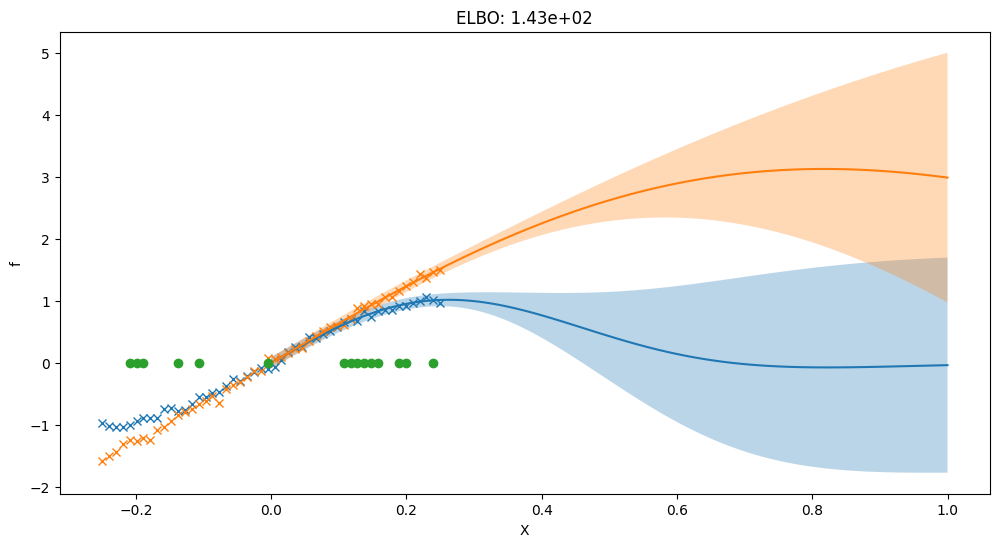

In [ ]:
# Create list of kernels for each output
kern_list = [
    gpflow.kernels.SquaredExponential() for _ in range(P)
]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)
)

# create SVGP model as usual and optimize
m = gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P
)

optimize_model_with_scipy(m)

gpflow.utilities.print_summary(m)
plot_model(m)

# Separate independent kernel and separate independent inducing variables

Here we allow different hyperparameters for the priors of each output. We now allow different inducing inputs for each output.

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.76297
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.29189
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,9.26971
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,0.859
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00198
SVGP.inducing_variable.inducing_variable_list[0].Z,Parameter,Identity,,True,"(15, 1)",float64,[[-0.1936...
SVGP.inducing_variable.inducing_variable_list[1].Z,Parameter,Identity,,True,"(15, 1)",float64,[[-0.14635...
SVGP.q_mu,Parameter,Identity,,True,"(15, 2)",float64,"[[-1.06613e+00, -3.07340e-01..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 15, 15)",float64,"[[[-1.4390e-02, 0.0000e+00, 0.0000e+00..."


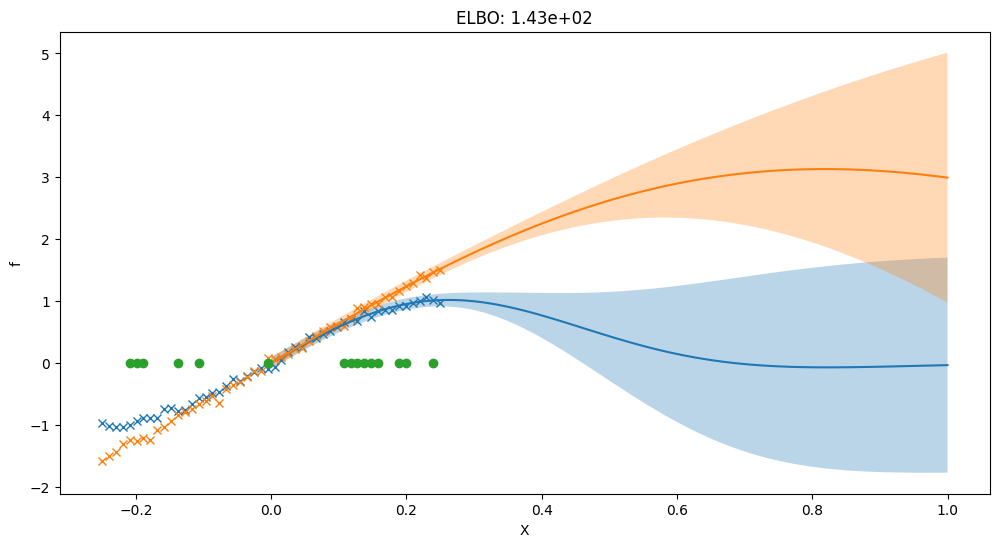

In [ ]:
# Create list of kernels for each output
kern_list = [
    gpflow.kernels.SquaredExponential() for _ in range(P)
]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.SeparateIndependent(kern_list)
# initialization of inducing input locations, one set of locations per output
Zs = [Zinit.copy() for _ in range(P)]
# initialize as list inducing inducing variables
iv_list = [gpflow.inducing_variables.InducingPoints(Z) for Z in Zs]
# create multi-output inducing variables from iv_list
iv = gpflow.inducing_variables.SeparateIndependentInducingVariables(iv_list)

m = gpflow.models.SVGP(
    kernel, gpflow.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=P
)

optimize_model_with_scipy(m)

gpflow.utilities.print_summary(m)
plot_model(m)

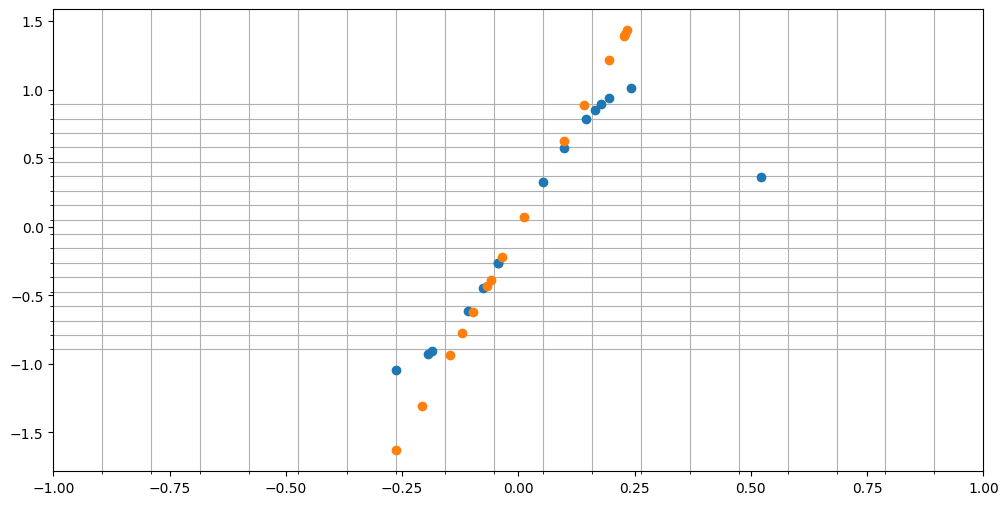

In [ ]:
for i in range(len(m.inducing_variable.inducing_variable_list)):
    q_mu_unwhitened, q_var_unwhitened = m.predict_f(
        m.inducing_variable.inducing_variable_list[i].Z
    )
    plt.plot(
        m.inducing_variable.inducing_variable_list[i].Z.numpy(),
        q_mu_unwhitened[:, i, None].numpy(),
        "o",
    )
plt.gca().set_xticks(np.linspace(-1, 1, 20), minor=True)
plt.gca().set_yticks(np.linspace(-1, 1, 20), minor=True)
plt.grid(which="minor")

# Mixed kernel and uncorrelated inducing variables


In [ ]:
# Create list of kernels for each output
kern_list = [
    gpflow.kernels.SquaredExponential() for _ in range(L)
]
# Create multi-output kernel from kernel list
kernel = gpflow.kernels.LinearCoregionalization(
    kern_list, W=np.random.randn(P, L)
)  # Notice that we initialise the mixing matrix W
# initialisation of inducing input locations (M random points from the training inputs)
Z = Zinit.copy()
# create multi-output inducing variables from Z
iv = gpflow.inducing_variables.SharedIndependentInducingVariables(
    gpflow.inducing_variables.InducingPoints(Z)
)

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.84881
SVGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.43732
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.06093
SVGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,2.82625
SVGP.kernel.W,Parameter,Identity,,True,"(2, 2)",float64,"[[-1.29118e+00, 6.20000e-04..."
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.00361
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(15, 1)",float64,[[-0.12963...
SVGP.q_mu,Parameter,Identity,,True,"(15, 2)",float64,"[[5.61730e-01, 2.83900e-02..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 15, 15)",float64,"[[[7.76000e-03, 0.00000e+00, 0.00000e+00..."


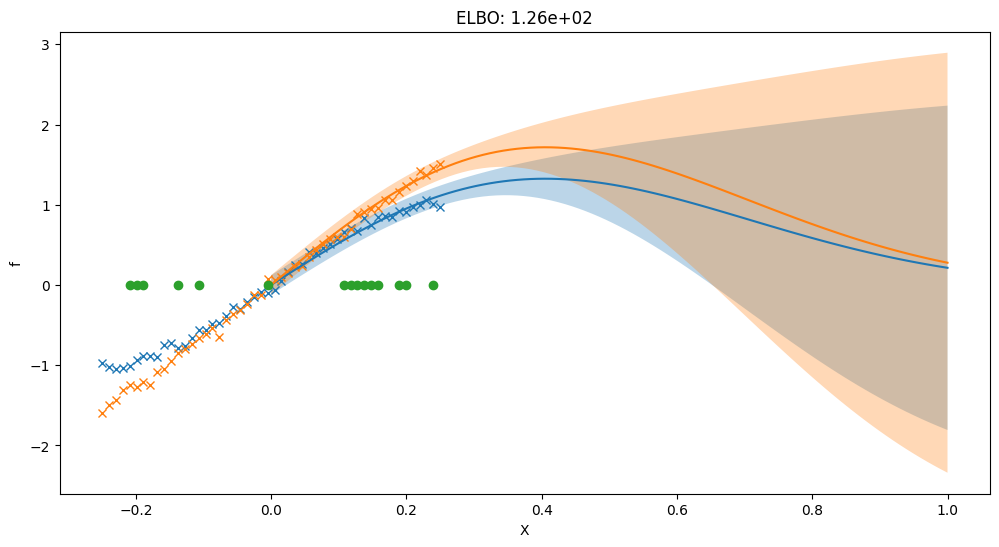

In [ ]:
# initialize mean of variational posterior to be of shape MxL
q_mu = np.zeros((M, L))
# initialize \sqrt(Σ) of variational posterior to be of shape LxMxM
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

# create SVGP model as usual and optimize
m = gpflow.models.SVGP(
    kernel,
    gpflow.likelihoods.Gaussian(),
    inducing_variable=iv,
    q_mu=q_mu,
    q_sqrt=q_sqrt,
)

optimize_model_with_scipy(m)

gpflow.utilities.print_summary(m)
plot_model(m)